In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
plt.style.use("ggplot")
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pickle


# Exercise 3

## 0.From previously

In [14]:
# year = "2019"
# data_dir = u"../Data/"
# bin_sample_path = f"{data_dir}binSamples/"
# fill_sample_path = f"{data_dir}fillSamples/"
# result_path = f"{data_dir}"

In [8]:
# flist = []
# for month_int in range(1,13):
#     month = '%02d' % month_int
#     filename = "bin%s%s.csv" % (year, month)
#     df = pd.read_csv(bin_sample_path+filename)
#     flist.append(df)

# df_out = pd.concat(flist, axis=0, ignore_index=False)
# df_out.to_csv(f"../Data/inter_results_pre_{year}all.csv")

Use all data

In [9]:
# # Running the steps from Exercise Class 2 to generate impact states for full 2019
# filename = f'inter_results_pre_{year}all.csv'
# stock_info_df = pd.read_csv(result_path+filename)

# traded_volume_df = stock_info_df[["stock", "date", "trade", "time"]].pivot(index=["stock", "date"], columns=["time"])["trade"].fillna(0).astype(int)
# px_df = stock_info_df[["stock", "date", "midEnd", "time"]].pivot(index=["stock", "date"], columns=["time"])["midEnd"].\
#     fillna(method="ffill", axis="columns").fillna(method="bfill", axis="columns")

# daily_stock_info_df = pd.DataFrame({
#     "px_vol": px_df.pct_change(1, axis="columns").std(axis="columns"),
#     "volume": traded_volume_df.abs().sum(axis="columns"),
# }).reset_index()

# num_days_precompute = 20
# stacked_info = daily_stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"])\
#                                   .rolling(num_days_precompute).mean().shift(0)

# monthly_stock_info_df = pd.DataFrame({
#     "px_vol": stacked_info.px_vol.unstack(),
#     "volume": stacked_info.volume.unstack(),
# }).reset_index()

# monthly_scaling_factor = monthly_stock_info_df.set_index(["stock", "date"]).loc[traded_volume_df.index]
# half_life = 3600
# model_type = 'linear'


/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_47684/1905700549.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fillna(method="ffill", axis="columns").fillna(method="bfill", axis="columns")


In [5]:
# list_by_month = []
# price_by_month = []
# volume_by_month = []

# for month_int in range(1, 13):
#     bin_sample_path = f"{data_dir}binSamples/"
#     month = '%02d' % month_int
#     filename = "bin%s%s.csv" % (year, month)
#     bin_sample_df = pd.read_csv(bin_sample_path+filename)
    
#     price_df = bin_sample_df[["date", "time", "stock", "midEnd"]]\
#                 .pivot(index=["stock", "date"], columns="time")\
#                 .bfill(axis=1).ffill(axis=1)

#     traded_volume_df = bin_sample_df[["stock", "date", "trade", "time"]].\
#                     pivot(index=["stock", "date"], columns="time", values="trade").\
#                     fillna(0)
    
#     monthly_df = pd.DataFrame({
#         "price volatility": price_df.pct_change(axis=1).std(axis=1),
#         "ave daily volume": traded_volume_df.abs().sum(axis=1)})
    
#     list_by_month.append(monthly_df)
#     price_by_month.append(price_df)
#     volume_by_month.append(traded_volume_df)
    
# all_month_df = pd.concat(list_by_month)

# rolling = 20
# mean_info = all_month_df.groupby('stock').rolling(rolling).mean()
# mean_info.index = mean_info.index.droplevel(0)
# mean_info = mean_info.reset_index()
# mean_info = mean_info.set_index(["stock", "date"])

# all_price = pd.concat(price_by_month)["midEnd"]
# all_volume = pd.concat(volume_by_month)

In [4]:
def load_from_pickle(filename):
    path = '../../pkl_dump/'
    with open(path + filename, 'rb') as f:
        return pickle.load(f)

# Load data
traded_volume_df = load_from_pickle('traded_volume_df.pkl')
px_df = load_from_pickle('px_df.pkl')
daily_stock_info_df = load_from_pickle('daily_stock_info_df.pkl')
monthly_scaling_factor = load_from_pickle('monthly_scaling_factor.pkl')
stocks = traded_volume_df.reset_index()["stock"].unique()

# other params
half_life = 3600
model_type = 'linear'

`impact_state` function

In [5]:
def impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type):
    # space kernels
    space_kernels = {
        "linear": lambda x: x,
        "sqrt": lambda x: np.sign(x) * np.sqrt(np.abs(x)),
    }

    beta = np.log(2) / half_life
    time_unit = 10  # 10 seconds
    decay_factor = np.exp(-beta * time_unit)
    pre_ewm = traded_volume_df
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["volume"], axis="rows")
    pre_ewm = space_kernels[model_type](pre_ewm)
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["px_vol"], axis="rows")

    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
    cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns
    return cum_impact

impact_px_df = impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type)

/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_95294/2775272740.py:17: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns


## 1. Fit price impact model

$\text{Maths notation}$: `variables`

$\Delta I $: `impact_changes` \
$\Delta P $: `returns` (?? Why it's percentage changes)

$$
\begin{aligned}
\Delta P_t &= \Delta S_t + 
\end{aligned}
$$


In [6]:
# explanation_horizon_periods means the number of 10s for the explanation horizon
# for 10 seconds explanation horizon, explanation_horizon_periods should be 1
# for 10 minutes explanation horizon, explanation_horizon_periods should be 60
def impact_regression_statistics(cum_impact, explanation_horizon_periods, px_df):
    # Diff for non-cumulative impact for given bin (column)
    impact_changes = cum_impact.diff(explanation_horizon_periods, axis="columns").T.unstack()
    req_stat_df = impact_changes.reset_index().rename({0: "x"}, axis="columns")
    # Not completely sure why we remove before 10:00
    req_stat_df = req_stat_df.loc[req_stat_df["time"] >= "10:00"].dropna(axis=0).copy()

    # pct_change for percentage returns between bins
    returns = px_df.pct_change(explanation_horizon_periods, axis="columns").T.unstack()
    returns = returns.reset_index().rename({0: "y"}, axis="columns")

    # Adding the y for price returns to the same req_stat_df
    req_stat_df["y"] = returns["y"]  # joins on index even though req_stat_df shorter
    req_stat_df["xy"] = req_stat_df["x"] * req_stat_df["y"]
    req_stat_df["xx"] = req_stat_df["x"] * req_stat_df["x"]
    req_stat_df["yy"] = req_stat_df["y"] * req_stat_df["y"]
    req_stat_df["count"] = 1

    return req_stat_df

In [7]:
# Computing unsummed regression products for horizon of 1 minute
daily_stock_reg_info_df = impact_regression_statistics(impact_px_df, 6, px_df)
# Not sure why excluding negative returns or }small returns
daily_stock_reg_info_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["y"] >= 0.0001].copy()
daily_stock_reg_info_df["date"] = pd.to_datetime(daily_stock_reg_info_df["date"])
# daily_stock_reg_info_df


,stock,date,time,x,y,xy,xx,yy,count
44661,A,2019-01-30,10:00:20,6.002474e-07,0.000815,4.894319e-10,3.602970e-13,6.648504e-07,1
44662,A,2019-01-30,10:00:30,3.012715e-07,0.001224,3.686280e-10,9.076452e-14,1.497134e-06,1
44663,A,2019-01-30,10:00:40,1.517813e-07,0.001360,2.064350e-10,2.303757e-14,1.849822e-06,1
44664,A,2019-01-30,10:00:50,1.470221e-07,0.001496,2.199582e-10,2.161548e-14,2.238285e-06,1
44665,A,2019-01-30,10:01:00,1.452501e-07,0.001836,2.666771e-10,2.109760e-14,3.370842e-06,1
...,...,...,...,...,...,...,...,...,...
29033071,ARE,2019-12-27,15:58:20,1.741800e-06,0.000187,3.258746e-10,3.033867e-12,3.500294e-08,1
29033072,ARE,2019-12-27,15:58:30,1.379788e-06,0.000125,1.720970e-10,1.903814e-12,1.555686e-08,1
29033079,ARE,2019-12-27,15:59:40,6.483263e-07,0.000218,1.415074e-10,4.203270e-13,4.763993e-08,1
29033080,ARE,2019-12-27,15:59:50,1.289552e-06,0.000281,3.618835e-10,1.662943e-12,7.875171e-08,1


Linear regression but not using matrix forms for memory usage
-   Use in-sample and out-of-sample $R^2$
$$
SS_{xx} = \sum (x - \bar{x})^2 = \sum x^2 - \frac{(\sum x)^2}{n} \\
SS_{yy} = \sum (y - \bar{y})^2 = \sum y^2 - \frac{(\sum y)^2}{n} \\

SS_{xy} = \sum (x - \bar{x})(y - \bar{y}) = \sum xy - \frac{(\sum x)(\sum y)}{n} \\

r = \frac{SS_{xy}}{\sqrt{SS_{xx} \cdot SS_{yy}}}
\quad \quad
b_1 = \frac{SS_{xy}}{SS_{xx}}
$$

In [8]:
def regression_result(daily_stock_reg_info_df, in_sample_month):
    in_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month]
    out_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month + 1]

    # Sum products over all dates (in month) for each stock
    in_sample_summary_df = in_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()
    out_sample_summary_df = out_sample_df.groupby("stock")[["xy", "xx", "yy", "x", "y", "count"]].sum()

    in_sample_summary_df.columns = "is_" + in_sample_summary_df.columns
    out_sample_summary_df.columns = "oos_" + out_sample_summary_df.columns

    # Already summed over dates for each stock, IS and OOS now two sets of columns to combine
    summary_df = pd.merge(in_sample_summary_df, out_sample_summary_df, left_index=True, right_index=True, how="inner")

    # Slope_hat = S_xy / S_xx
    # I think the error was using is_x and is_y in computing expressions of beta
    summary_df["beta_estimate"] = (summary_df["is_xy"] - summary_df["is_x"] * summary_df["is_y"] / summary_df["is_count"]) / \
                                  (summary_df["is_xx"] - summary_df["is_x"]**2 / summary_df["is_count"])
    # Intercept_hat = y_bar - slope_hat * x_bar
    summary_df["alpha_estimate"] = (summary_df["is_y"] / summary_df["is_count"]) - \
                                   (summary_df["beta_estimate"] * summary_df["is_x"] / summary_df["is_count"])

    # SSE = Sum(y - yBar)^2 = S_yy - S_y^2/n
    summary_df["is_sse"] = (summary_df["is_yy"] - summary_df["is_y"]**2 / summary_df["is_count"])  # typo here??
    summary_df["is_mse"] = (summary_df["is_yy"]
                           - 2 * summary_df["alpha_estimate"] * summary_df["is_y"]
                           - 2 * summary_df["beta_estimate"] * summary_df["is_xy"]
                           + 2 * summary_df["beta_estimate"] * summary_df["is_x"] * summary_df["alpha_estimate"]
                           + summary_df["beta_estimate"]**2 * summary_df["is_xx"]
                           + summary_df["alpha_estimate"]**2 * summary_df["is_count"])

    # R^2 = 1 - MSE/SSE
    summary_df["is_rsq"] = 1 - (summary_df["is_mse"] / summary_df["is_sse"])

    summary_df["oos_sse"] = (summary_df["oos_yy"] - summary_df["oos_y"]**2 / summary_df["oos_count"])
    summary_df["oos_mse"] = (summary_df["oos_yy"]
                            - 2 * summary_df["alpha_estimate"] * summary_df["oos_y"]
                            - 2 * summary_df["beta_estimate"] * summary_df["oos_xy"]
                            + 2 * summary_df["beta_estimate"] * summary_df["oos_x"] * summary_df["alpha_estimate"]
                            + summary_df["beta_estimate"]**2 * summary_df["oos_xx"]
                            + summary_df["alpha_estimate"]**2 * summary_df["oos_count"])

    summary_df["oos_rsq"] = 1 - (summary_df["oos_mse"] / summary_df["oos_sse"])

    return summary_df


In [9]:
in_sample_month = 5
summary_df = regression_result(daily_stock_reg_info_df, in_sample_month)
summary_df = summary_df[['beta_estimate', 'alpha_estimate', 'is_rsq', 'oos_rsq']]
summary_df

,beta_estimate,alpha_estimate,is_rsq,oos_rsq
stock,,,,
A,85.021725,0.000558,0.024063,-0.109038
AAL,100.032251,0.000648,0.051204,0.068017
AAP,125.527825,0.000554,0.061591,0.023734
AAPL,277.467167,0.000482,0.157565,-0.127719
ABBV,135.922632,0.000487,0.045509,0.120975
ABC,99.919600,0.000599,0.025915,-0.009289
ABMD,175.680700,0.000772,0.071054,-0.174724
ABT,147.981265,0.000444,0.057783,-0.066515
ACN,140.837356,0.000391,0.041441,-0.049647


# Exercise 4

In [10]:
def impact_resultant_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    trades_copy = trades.copy()
    trades_copy = kernel(trades_copy)
    trades_copy[1:] /= (1 - decay)
    cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean()
    cum_impacts *= price_vol / kernel(ADV)
    cum_returns = prices / prices[0] - 1
    cum_returns += cum_impacts * impact_coef
    return prices[0] * (cum_returns + 1)


In [11]:
month = 2
linear_impact_coef_df = summary_df.reset_index()
scaling_df = monthly_scaling_factor

## 1. Synthetic Alpha

In [12]:
px_df2 = px_df.loc["AAPL"]
px_df2 = px_df2.iloc[px_df2.index < "2019-02-01"]

In [13]:
explanation_horizon_periods = 6  # Number of bins
returns = px_df2.T.pct_change(explanation_horizon_periods, axis=0)  # each day for AAPL

actual_variance = returns.unstack().var()
average_power_neg2 = (px_df2 ** (-2)).mean().mean()


Compute synthetic alpha:
1. Get $x, y$
2. Verify corr and var
3. Smooth synthetic alphas using EMA `df.ewm().mean()`

In [14]:
required_corr = 0.6
x = required_corr ** 2
y = required_corr * np.sqrt((1 - required_corr ** 2)) * np.sqrt(actual_variance / explanation_horizon_periods / average_power_neg2)
#y = ((1 - x ** 2) * actual_variance / average_power_neg2 / explanation_horizon_periods) ** (1/2)
# x, y


In [15]:
x, y

(0.36, 0.021363950235674656)

In [16]:
# Verify correlation and variance is as desired
np.random.seed(42)

returns = px_df2.T.pct_change(explanation_horizon_periods, axis=0).iloc[explanation_horizon_periods::]
returns.index.name = "time"

px_changes = px_df2.T.diff(explanation_horizon_periods, axis=0).iloc[explanation_horizon_periods::]
W_diffs = np.random.normal(loc=0, scale=1.0, size=(px_df2.shape[0], px_df2.shape[1]-1))
Ws = np.concatenate((np.zeros((W_diffs.shape[0], 1)), W_diffs.cumsum(axis=1)), axis=1).T
W_h_diffs = Ws[explanation_horizon_periods::] - Ws[:-explanation_horizon_periods]
px_changes = px_changes * x + W_h_diffs * y
synthetic_returns = px_changes / (px_df2.T.shift(1, axis=0))
synthetic_returns.index.name = "time"

returns_df = pd.DataFrame({
    "actual": returns.unstack(),
    "synthetic": synthetic_returns.unstack(),
})

correlation = returns_df.corr().iloc[0,1]
actual_variance = returns_df["actual"].var()
synthetic_variance = returns_df["synthetic"].var()

(correlation, actual_variance, synthetic_variance)


(0.6075877759363079, 5.039766022533437e-07, 1.8421910942477703e-07)

In [17]:
synthetic_alpha_diffs = returns_df.drop("actual", axis="columns").unstack("time")["synthetic"]
# Cumulative sum of alphas from reversed time
synthetic_alphas = synthetic_alpha_diffs.iloc[:, ::-1].cumsum(axis="columns").iloc[:,::-1].shift(-1, axis="columns").fillna(0)

# Visualising alpha returns
# synthetic_alpha_diffs.iloc[:, ::-1]


In [18]:
# Smoothing
smooth_synthetic_alphas = synthetic_alphas.ewm(halflife=200, axis="columns").mean()

/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_95294/2365349347.py:2: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  smooth_synthetic_alphas = synthetic_alphas.ewm(halflife=200, axis="columns").mean()


## 2. Backtesting

In [19]:
time_unit = 10  # 10 seconds
half_life = 3600
beta = np.log(2) / half_life
decay_factor = np.exp(-beta * time_unit)

def sqrt_kernel(values):
    return np.sqrt(np.abs(values)) * np.sign(values)

def linear_kernel(values):
    return values


In [20]:
def impact_adjusted_prices(pre_ewm, px_df, scaling_df, half_life, impact_coef_df, model_type):
    cum_impacts = impact_state(pre_ewm, scaling_df, half_life, model_type).T
    cum_returns = px_df.T / px_df.T.iloc[0, :] - 1
    stock_date_df = cum_returns.T.iloc[:, 0].reset_index()
    # stock_date_df["month"] = pd.to_datetime(stock_date_df["date"]).dt.month
    stock_date_df.drop(["date"], axis="columns", inplace=True)
    impact_coefficients = pd.merge(stock_date_df, impact_coef_df, on=["stock"], how="left")["beta_estimate"].values
    cum_returns -= cum_impacts * impact_coefficients
    adjusted_px_df = (px_df.T.iloc[0, :] * (cum_returns + 1)).T.reset_index()
    return adjusted_px_df


In [21]:
def strategy_adjusted_prices(pre_ewm, adjusted_px_df, scaling_df, decay_factor, impact_coef_df, kernel):
    pre_ewm_copy = pre_ewm.copy()
    pre_ewm_copy = kernel(pre_ewm_copy)
    pre_ewm_copy.iloc[:, 1:] /= (1 - decay_factor)
    cum_impacts = pre_ewm_copy.ewm(alpha=1-decay_factor, adjust=False).mean()
    scaler_df = pd.merge(cum_impacts.T.iloc[:, 0], scaling_df, on=["stock", "date"])
    cum_impacts *= (scaler_df["px_vol"] / kernel(scaler_df["volume"])).values
    cum_returns = adjusted_px_df.T / adjusted_px_df.T.iloc[:, 0] - 1
    stock_date_df = cum_returns.T.iloc[:, 0].reset_index()
    stock_date_df.drop(["date"], axis="columns", inplace=True)
    impact_coefficients = pd.merge(stock_date_df, impact_coef_df, on=["stock"], how="left")["beta_estimate"].values
    cum_returns += cum_impacts * impact_coefficients
    strategy_adjusted_px_df = (adjusted_px_df.T.iloc[:, 0] * (cum_returns + 1)).T.reset_index()
    return strategy_adjusted_px_df

def impact_resultant_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    trades_copy = trades.copy()
    trades_copy = kernel(trades_copy)
    trades_copy.iloc[:, 1:] /= (1 - decay)
    cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean()
    cum_impacts *= price_vol / kernel(ADV)
    cum_returns = prices / prices[0] - 1
    cum_returns += cum_impacts * impact_coef
    return prices[0] * (cum_returns + 1)


In [26]:
smooth_synthetic_alphas_series

time
09:30:00    0.000000
09:30:10    0.000000
09:30:20    0.000000
09:30:30    0.000000
09:30:40    0.000000
              ...   
15:59:20    0.004136
15:59:30    0.004121
15:59:40    0.004107
15:59:50    0.004094
16:00:00    0.004080
Name: 2019-01-31, Length: 2341, dtype: float64

In [22]:
stock = "AAPL"
date = "2019-01-31"
# Assuming linear_impact_coef_df contains only month==2 example in-sample
smooth_synthetic_alphas_series = smooth_synthetic_alphas.loc[date]
px_vol, ADV = scaling_df.loc[stock, date]
linear_impact_coef = linear_impact_coef_df.loc[(linear_impact_coef_df["stock"]==stock), "beta_estimate"].iloc[0]
month_int = 2

px_df2 = impact_adjusted_prices(traded_volume_df.copy(), px_df, scaling_df, half_life, linear_impact_coef_df, "linear")
# px_df2 = impact_adjusted_prices(traded_volume_df.copy(), px_df, scaling_df, decay_factor, linear_impact_coef_df, linear_kernel)
prices = px_df2.loc[(px_df2["stock"]==stock) & (px_df2["date"]==date)]


/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_95294/2775272740.py:17: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns


In [24]:
# Trade size achieving the optimal impact tagrte
intended_impacts = 1/2 * (smooth_synthetic_alphas_series - smooth_synthetic_alphas_series.diff(1).shift(-1).fillna(0) / beta / time_unit)
intended_impacts.iloc[-1] = smooth_synthetic_alphas_series.iloc[-1] # I_T^* = \alpha_T

optimal_trades = (beta * (smooth_synthetic_alphas_series
                - smooth_synthetic_alphas_series.diff(1).diff(1).shift(-1).fillna(0) / (beta ** 2 * time_unit ** 2)
                ) / (px_vol / ADV * linear_impact_coef) / 2 * time_unit
                )
                
# dQ_t * time_unit (10 seconds)
optimal_trades.iloc[0] = intended_impacts.iloc[0] / (px_vol / ADV * linear_impact_coef) # I_0^* / lambda
optimal_trades.iloc[-1] += (smooth_synthetic_alphas_series.iloc[-1] - intended_impacts.iloc[-2] * decay_factor) / (px_vol / ADV * linear_impact_coef)
pct_synthetic_alpha_optimal_trades = optimal_trades / ADV
total_trade_sizes = pct_synthetic_alpha_optimal_trades.abs().sum()


In [51]:
pct_synthetic_alpha_optimal_trades

time
09:30:00     0.000000
09:30:10     0.000000
09:30:20     0.000000
09:30:30     0.000000
09:30:40    22.268551
              ...    
15:59:20    -0.002678
15:59:30    -0.002545
15:59:40    -0.001928
15:59:50     0.003200
16:00:00    -0.027118
Name: 2019-01-31, Length: 2341, dtype: float64

$$
\text{Fundamental Gain} \\
\int_{0}^{T} Q_t \, dS_t \\

\text{Impact cost} \\
\int_{0}^{T} I_t \, dQ_t
$$

In [52]:
Qs = optimal_trades.cumsum()
fundamental_gain = prices.pct_change(1) * Qs.shift(-1)
impact_cost = -intended_impacts * optimal_trades.shift(-1)
pnls = (fundamental_gain + impact_cost).fillna(0).cumsum()
trade_notional = (optimal_trades.abs() * prices).sum()


/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_82494/4271647426.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(prices.T.index[202:]), smooth_synthetic_alphas_series.values[200:], label="Synthetic alpha")
/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_82494/4271647426.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(prices.T.index[202:]), intended_impacts.values[200:], label="Impacts")


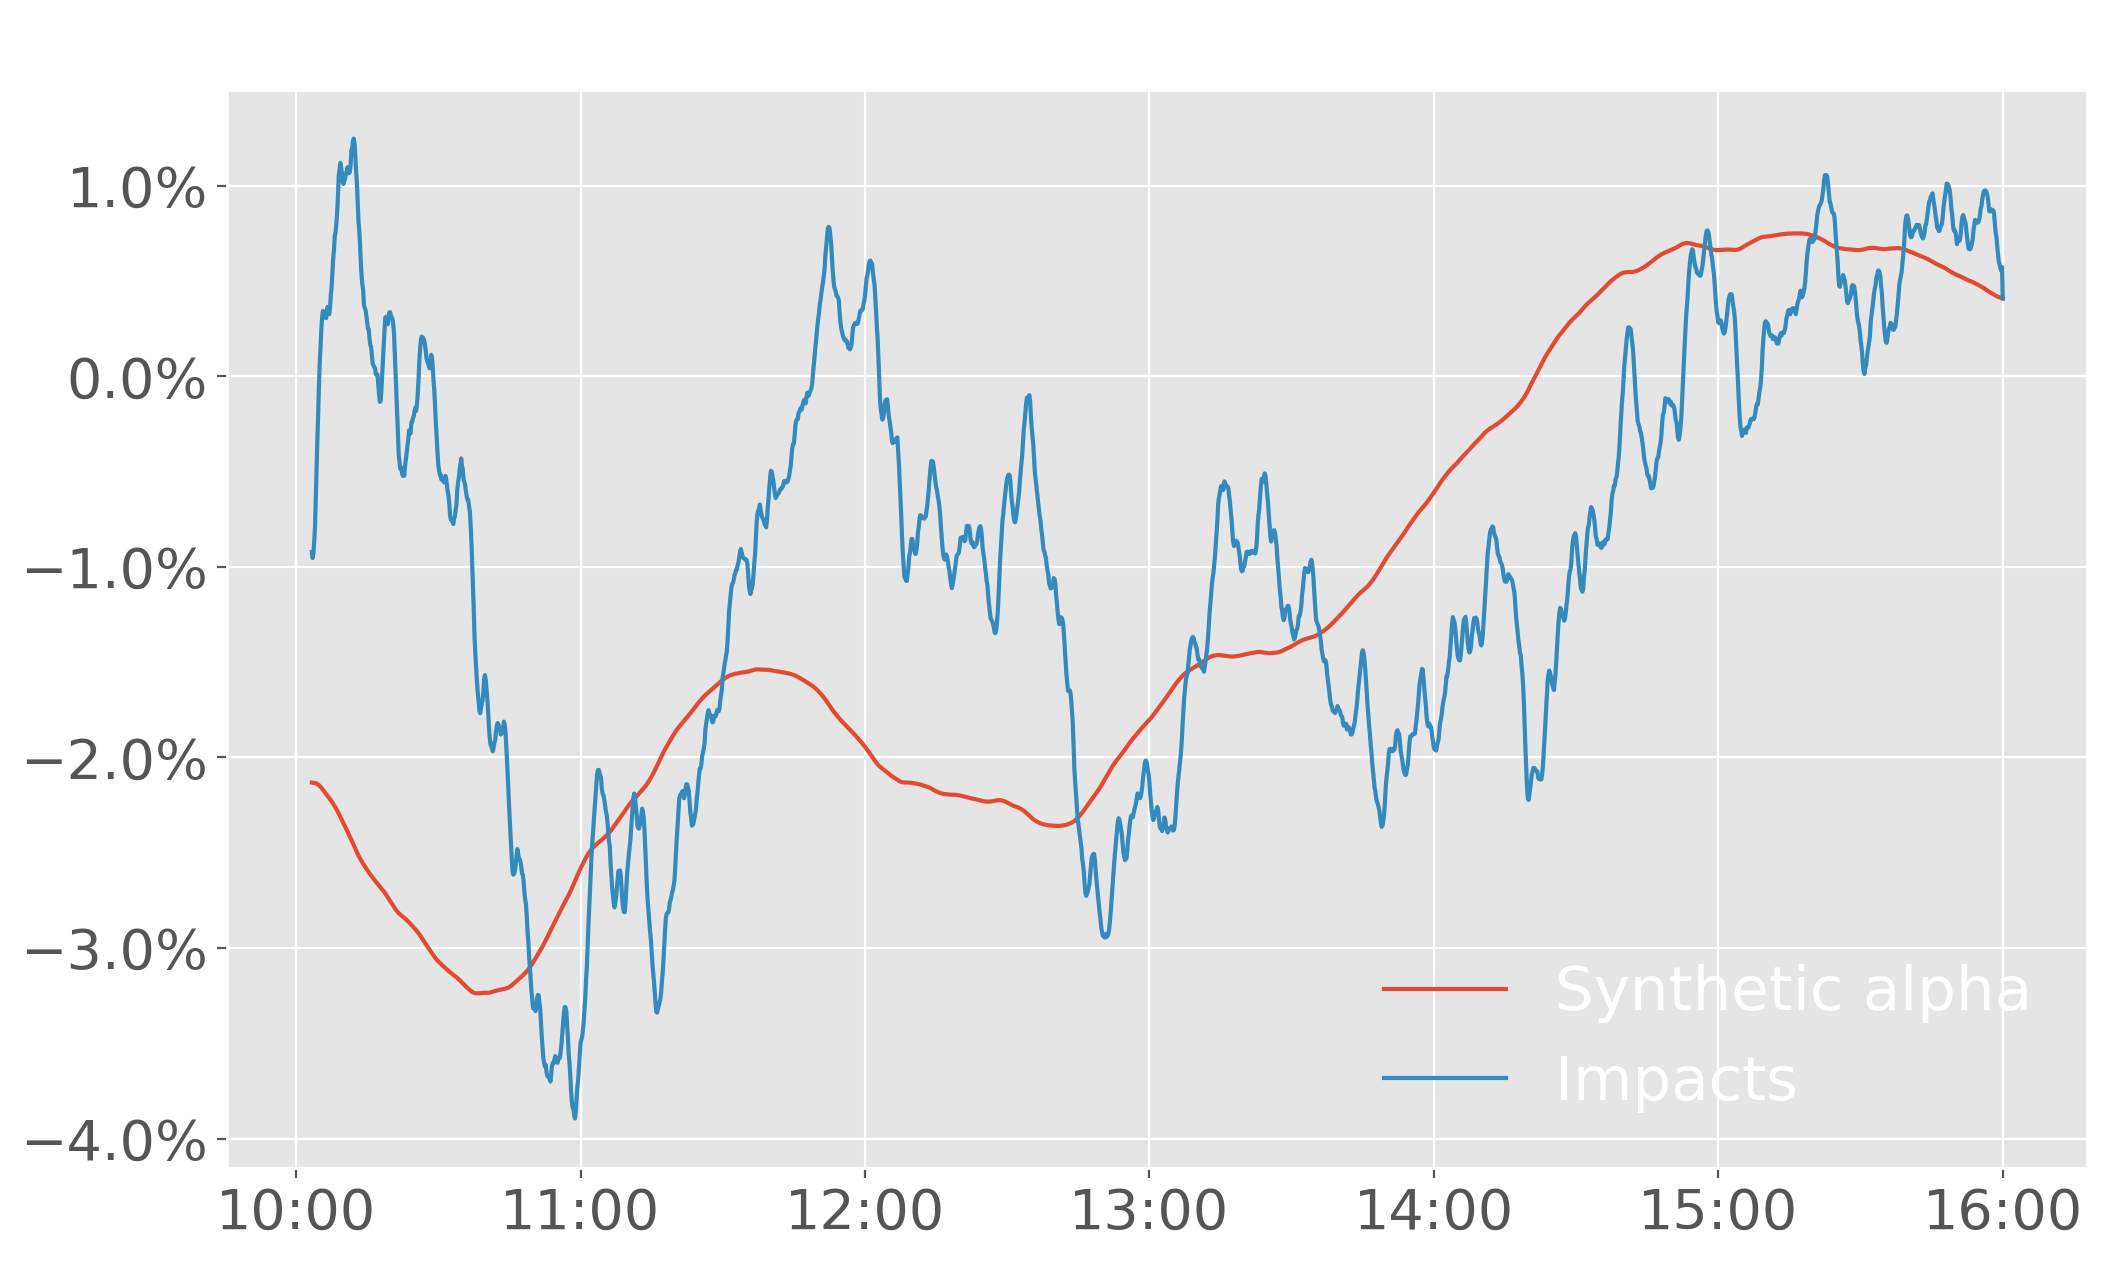

In [61]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)

ax.plot(pd.to_datetime(prices.T.index[202:]), smooth_synthetic_alphas_series.values[200:], label="Synthetic alpha")
ax.plot(pd.to_datetime(prices.T.index[202:]), intended_impacts.values[200:], label="Impacts")

ax.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title(f"{stock} on {date}", fontsize=25)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
ax.legend(fontsize=22, frameon=False)
# plt.close()
plt.show()
# Image("../images/EX4-1.png")


/var/folders/cb/0qjpmgyd53q970hhrqhbcvhr0000gn/T/ipykernel_82494/3059372531.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(px_df2.T.index[202:]), pct_synthetic_alpha_optimal_trades.cumsum().values[200:], label="Cumulative trades / ADV")


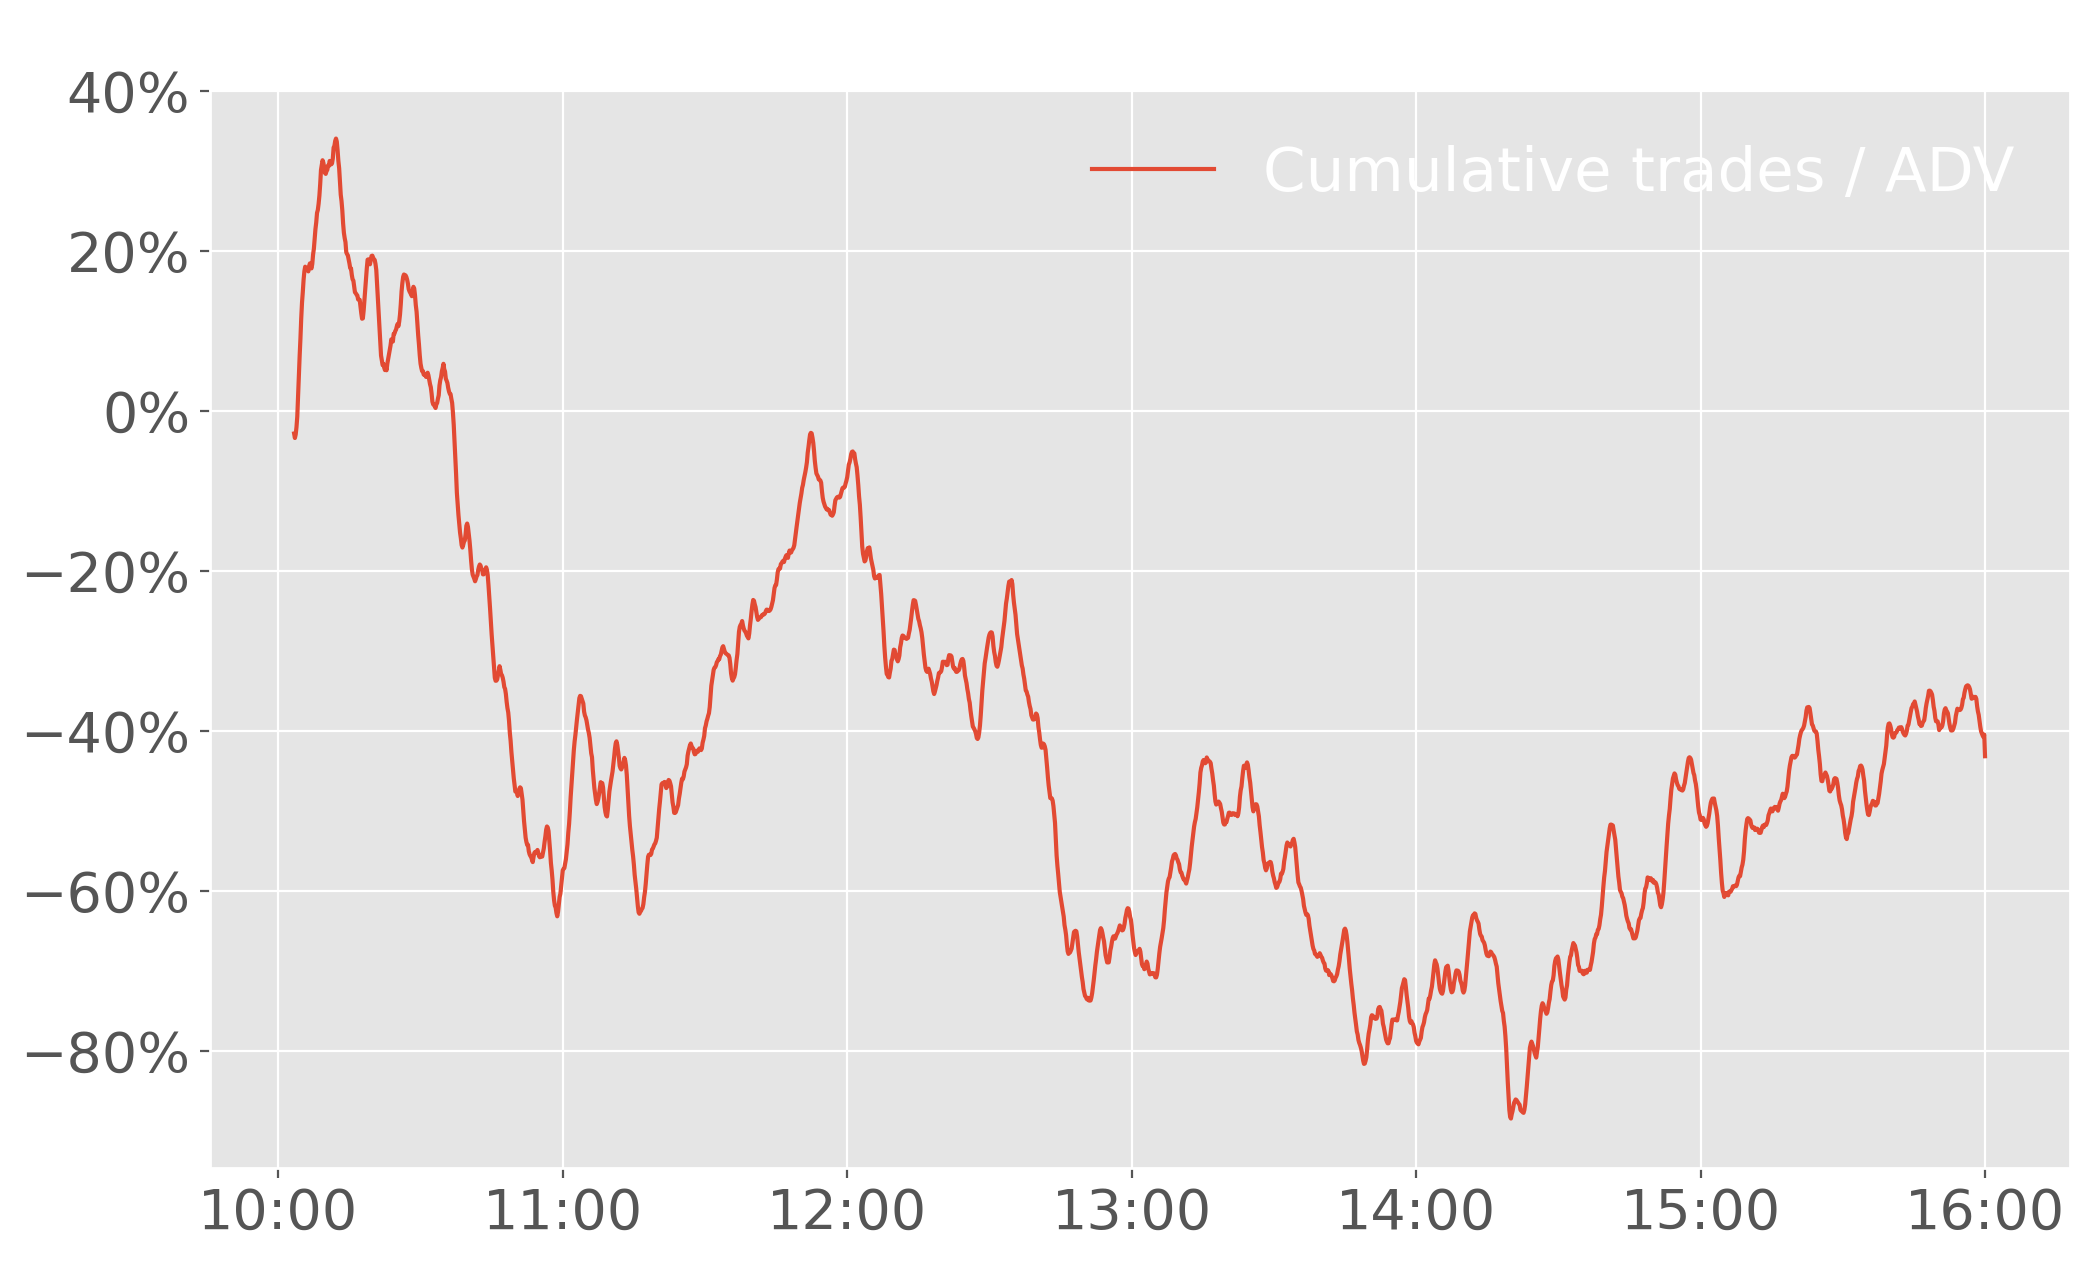

In [69]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)

ax.plot(pd.to_datetime(px_df2.T.index[202:]), pct_synthetic_alpha_optimal_trades.cumsum().values[200:], label="Cumulative trades / ADV")

# ax.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title(f"{stock} on {date}", fontsize=25)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
ax.legend(fontsize=22, frameon=False)
# plt.close()

# Image("../images/EX4-2.png")


In [ ]:
model_type = "linear"
month = "02"

pre_ewm = synthetic_alpha_optimal_trades.loc[adjusted_px_df.index]
strategy_adjusted_px_df = strategy_adjusted_prices(pre_ewm, adjusted_px_df, scaling_df, decay_factor, linear_impact_coef_df, linear_kernel)

fig = plt.figure(figsize=(22,7))
ax = plt.subplot(111)

ax.plot(pd.to_datetime(px_df2.columns), adjusted_px_df.loc[stock, date], label="Impact-adjusted price")
ax.plot(pd.to_datetime(px_df2.columns), synthetic_alpha_adjusted_px_df2.loc[stock, date], label="Synthetic alpha-adjusted price")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(f"{stock} on {date}", fontsize=25)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
ax.legend(fontsize=22, frameon=False)
plot_path = "/content/drive/My Drive/Plots/"
filename = f"{stock}_{date}_{model_type}_impact_adjustment.pdf"
plt.savefig(plot_path+filename, bbox_inches="tight")
plt.close()

Image("../images/EX4-3.png")
